In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Data loading and cleaning

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
str_cols = list(df.dtypes[df.dtypes == 'object'].keys())
str_cols.remove('customerid')
for col in str_cols:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [6]:
df['churn'] = (df['churn'] == 'yes').astype(int)
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.totalcharges.isna().sum()

0

### Data splitting and one-hot encoding

In [7]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [8]:
numeric_cols = ['tenure', 'monthlycharges', 'totalcharges']
categorical_cols = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']

In [9]:
from sklearn.feature_extraction import DictVectorizer

dicts = df_train[categorical_cols + numeric_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(dicts)

DictVectorizer(sparse=False)

In [10]:
X_train = dv.transform(df_train[categorical_cols + numeric_cols].to_dict(orient='records'))
y_train = df_train.churn

X_val = dv.transform(df_val[categorical_cols + numeric_cols].to_dict(orient='records'))
y_val = df_val.churn

X_test = dv.transform(df_test[categorical_cols + numeric_cols].to_dict(orient='records'))
y_test = df_test.churn

### Logistic regresion model training and accuracy calculation

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5).astype(int)
(y_val == churn_decision).mean()

0.801277501774308

In [13]:
dicision_boundaries = np.linspace(0,1,21)

0.0	0.269
0.05	0.534
0.1	0.615
0.15	0.665
0.2	0.704
0.25	0.742
0.3	0.764
0.35	0.774
0.4	0.784
0.45	0.793
0.5	0.801
0.55	0.801
0.6	0.785
0.65	0.774
0.7	0.763
0.75	0.741
0.8	0.735
0.85	0.731
0.9	0.731
0.95	0.731
1.0	0.731
Best threshold is 0.5 with accuracy 0.801277501774308


<Axes: >

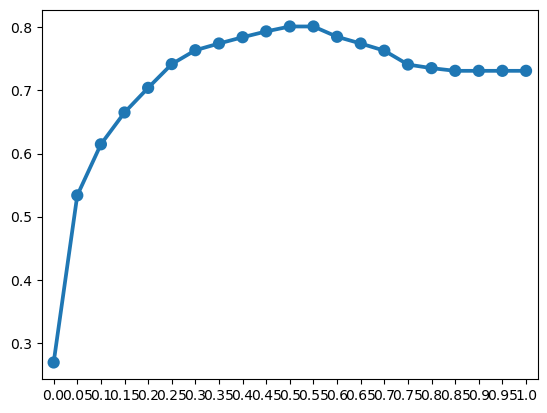

In [14]:
from sklearn.metrics import accuracy_score
max_accu = (0, 0)
ts = []
accus = []
for t in dicision_boundaries:
    accu = accuracy_score(y_val, y_pred >= t)
    if accu > max_accu[1]:
        max_accu = (t, accu)
    print(f"{round(t, 3)}\t{round(accu, 3)}")
    ts.append(round(t, 2))
    accus.append(round(accu, 6))
print(f"Best threshold is {max_accu[0]} with accuracy {max_accu[1]}")
sns.pointplot(x=ts, y=accus)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5) 

0.801277501774308

### Confusion table

In [16]:
actual_positives = (y_val == 1)
actual_negatives = (y_val == 0)

In [17]:
predict_positives = (y_pred >= 0.5)
predict_negatives = (y_pred < 0.5)

In [18]:
true_positives = (actual_positives & predict_positives).sum()
true_negatives = (actual_negatives & predict_negatives).sum()

In [19]:
true_positives, true_negatives

(201, 928)

In [20]:
false_positives = (actual_negatives & predict_positives).sum()
false_negatives = (actual_positives & predict_negatives).sum()

In [21]:
false_positives, false_negatives

(102, 178)

In [22]:
confusion_metrics = np.array([
    [true_negatives, false_positives],
    [false_negatives, true_positives]
])
confusion_metrics

array([[928, 102],
       [178, 201]], dtype=int64)

In [23]:
(confusion_metrics/len(X_val)).round(3)

array([[0.659, 0.072],
       [0.126, 0.143]])

### Precision and Recall

In [24]:
precision = true_positives/(true_positives + false_positives)
precision

0.6633663366336634

In [25]:
recall = true_positives/(true_positives + false_negatives)
recall

0.5303430079155673

In [26]:
def precision_recall(y_val, y_pred):
    scores = []
    for t in np.linspace(0, 1, 101):
        actual_positives = (y_val == 1)
        actual_negatives = (y_val == 0)
        predict_positives = (y_pred >= t)
        predict_negatives = (y_pred < t)
        true_positives = (actual_positives & predict_positives).sum()
        true_negatives = (actual_negatives & predict_negatives).sum()
        false_positives = (actual_negatives & predict_positives).sum()
        false_negatives = (actual_positives & predict_negatives).sum()

        scores.append((t, true_positives, true_negatives, false_positives, false_negatives))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives'])
    df_scores['precision'] = df_scores.true_positives/(df_scores.true_positives + df_scores.false_positives)
    df_scores['recall'] = df_scores.false_positives/(df_scores.false_positives + df_scores.true_negatives)
    return df_scores

In [27]:
p_r_df_scores = precision_recall(y_val, y_pred)
p_r_df_scores.iloc[::10]

,threshold,true_positives,true_negatives,false_positives,false_negatives,precision,recall
0,0.0,379,0,1030,0,0.268985,1.000000
10,0.1,354,512,518,25,0.405963,0.502913
20,0.2,319,673,357,60,0.471893,0.346602
30,0.3,286,790,240,93,0.543726,0.233010
40,0.4,243,862,168,136,0.591241,0.163107
50,0.5,201,928,102,178,0.663366,0.099029
60,0.6,138,968,62,241,0.690000,0.060194
70,0.7,63,1012,18,316,0.777778,0.017476
80,0.8,6,1030,0,373,1.000000,0.000000
90,0.9,0,1030,0,379,NaN,0.000000


<Axes: xlabel='threshold', ylabel='precision'>

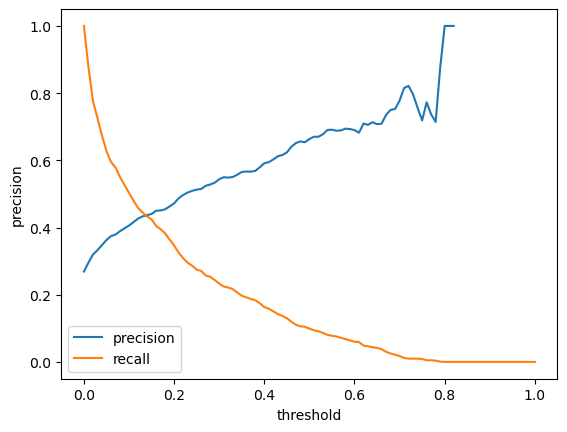

In [28]:
sns.lineplot(p_r_df_scores, x='threshold', y='precision', label='precision')
sns.lineplot(p_r_df_scores, x='threshold', y='recall', label="recall")

### ROC curves

In [29]:
true_positive_rate = true_positives/(true_positives+false_negatives)
true_positive_rate

0.5303430079155673

In [30]:
false_positive_rate = false_positives/(false_positives + true_negatives)
false_positive_rate

0.09902912621359224

In [31]:
def TPR_FPR(y_val, y_pred):
    scores = []
    for t in np.linspace(0, 1, 101):
        actual_positives = (y_val == 1)
        actual_negatives = (y_val == 0)
        predict_positives = (y_pred >= t)
        predict_negatives = (y_pred < t)
        true_positives = (actual_positives & predict_positives).sum()
        true_negatives = (actual_negatives & predict_negatives).sum()
        false_positives = (actual_negatives & predict_positives).sum()
        false_negatives = (actual_positives & predict_negatives).sum()

        scores.append((t, true_positives, true_negatives, false_positives, false_negatives))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives'])
    df_scores['true_positive_rate'] = df_scores.true_positives/(df_scores.true_positives + df_scores.false_negatives)
    df_scores['false_positive_rate'] = df_scores.false_positives/(df_scores.false_positives + df_scores.true_negatives)
    return df_scores

In [32]:
df_scores_real = TPR_FPR(y_val, y_pred)

<Axes: xlabel='threshold', ylabel='true_positive_rate'>

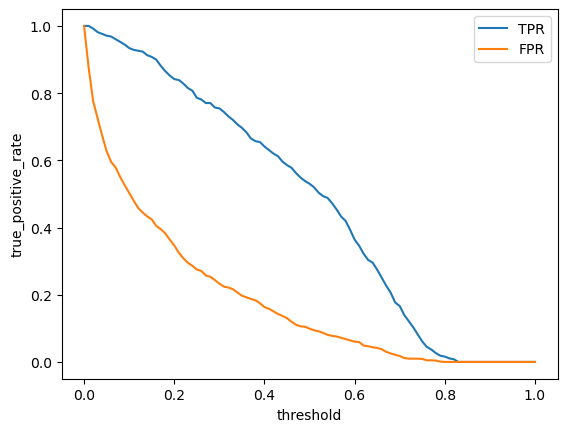

In [33]:
sns.lineplot(df_scores_real, x='threshold', y='true_positive_rate', label='TPR')
sns.lineplot(df_scores_real, x='threshold', y='false_positive_rate', label="FPR")

<Axes: xlabel='false_positive_rate', ylabel='true_positive_rate'>

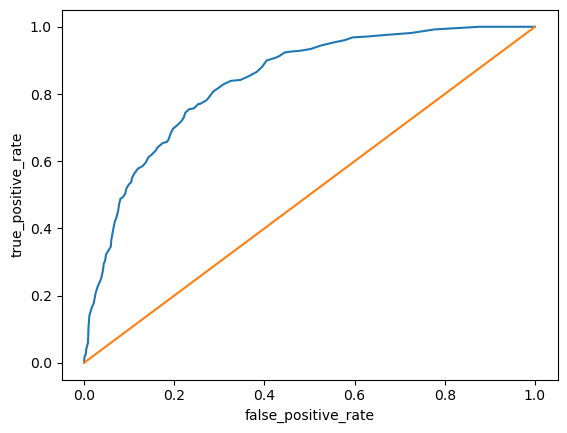

In [34]:
sns.lineplot(df_scores_real, y='true_positive_rate', x='false_positive_rate')
sns.lineplot(x=[0,1], y=[0,1])

#### Random model

In [35]:
np.random.seed(42)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [36]:
((y_rand > 0.5) == y_val).mean()

0.49893541518807666

<Axes: xlabel='threshold', ylabel='true_positive_rate'>

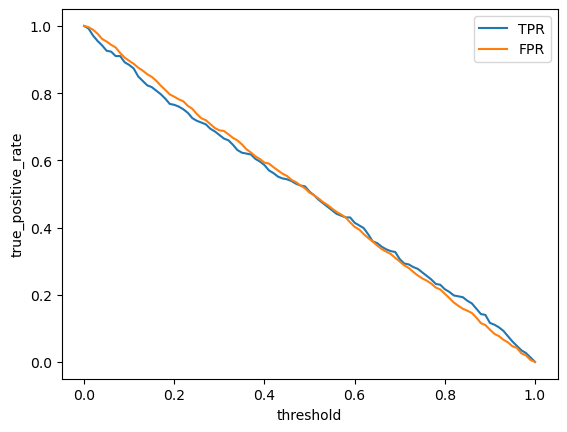

In [37]:
df_scores_rand = TPR_FPR(y_val, y_rand)
sns.lineplot(df_scores_rand, x='threshold', y='true_positive_rate', label='TPR')
sns.lineplot(df_scores_rand, x='threshold', y='false_positive_rate', label="FPR")

<Axes: xlabel='false_positive_rate', ylabel='true_positive_rate'>

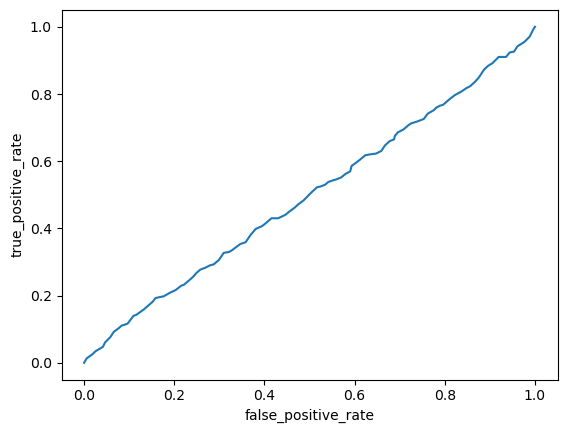

In [38]:
sns.lineplot(df_scores_rand, y='true_positive_rate', x='false_positive_rate')

#### Ideal model

In [39]:
(y_val == 0).sum(), (y_val == 1).sum(), 1- (y_val == 1).mean()

(1030, 379, 0.7310149041873669)

In [40]:
y_val_ideal = np.repeat([0,1], [1030, 379])
y_val_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [41]:
y_pred_ideal = np.linspace(0, 1, len(y_val))

In [42]:
((y_pred_ideal >= 0.731) == y_val_ideal).mean()

1.0

In [43]:
df_scores_ideal = TPR_FPR(y_val_ideal, y_pred_ideal)

<Axes: xlabel='threshold', ylabel='true_positive_rate'>

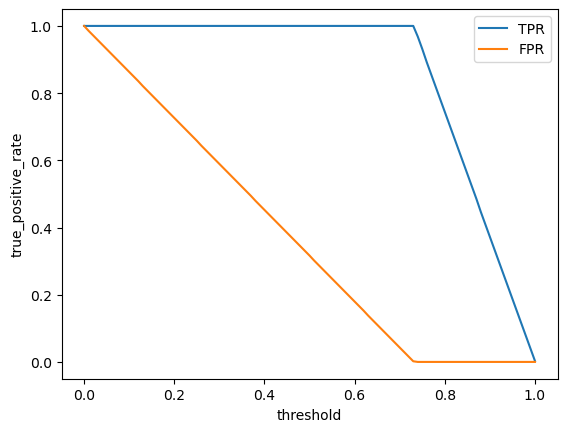

In [44]:
sns.lineplot(df_scores_ideal, x='threshold', y='true_positive_rate', label='TPR')
sns.lineplot(df_scores_ideal, x='threshold', y='false_positive_rate', label="FPR")

<Axes: xlabel='false_positive_rate', ylabel='true_positive_rate'>

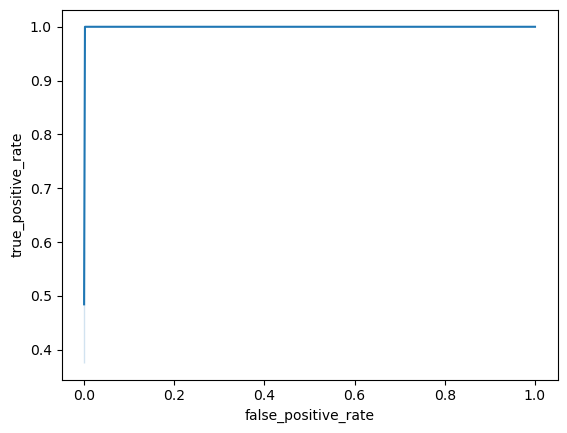

In [45]:
sns.lineplot(df_scores_ideal, y='true_positive_rate', x='false_positive_rate')

#### Together

<Axes: xlabel='threshold', ylabel='true_positive_rate'>

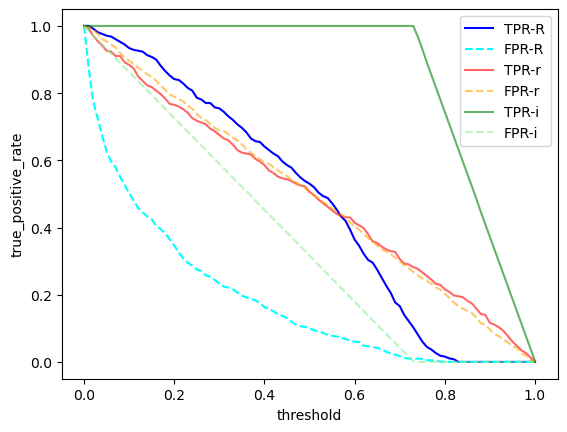

In [46]:
sns.lineplot(df_scores_real, x='threshold', y='true_positive_rate', label='TPR-R', color="blue")
sns.lineplot(df_scores_real, x='threshold', y='false_positive_rate', label="FPR-R", color="cyan", linestyle="--")

sns.lineplot(df_scores_rand, x='threshold', y='true_positive_rate', label='TPR-r', color="red", alpha=0.6)
sns.lineplot(df_scores_rand, x='threshold', y='false_positive_rate', label="FPR-r", color="orange", alpha=0.6, linestyle="--")

sns.lineplot(df_scores_ideal, x='threshold', y='true_positive_rate', label='TPR-i', color="green", alpha=0.6)
sns.lineplot(df_scores_ideal, x='threshold', y='false_positive_rate', label="FPR-i", color="lightgreen", alpha=0.6, linestyle="--")

<Axes: title={'center': 'ROC curve'}, xlabel='false_positive_rate', ylabel='true_positive_rate'>

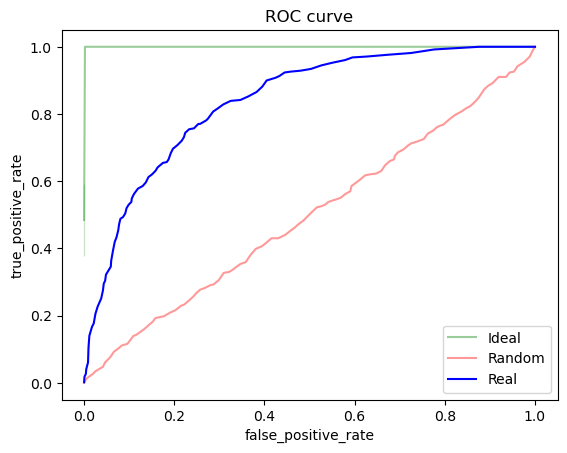

In [47]:
plt.title("ROC curve")
sns.lineplot(df_scores_ideal, y='true_positive_rate', x='false_positive_rate', label="Ideal", color="green", alpha=0.4)
sns.lineplot(df_scores_rand, y='true_positive_rate', x='false_positive_rate', label="Random", color="red", alpha=0.4)
sns.lineplot(df_scores_real, y='true_positive_rate', x='false_positive_rate', label="Real", color="blue")

In [48]:
from sklearn.metrics import roc_curve

In [49]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
len(fpr), len(tpr), len(thresholds)

(379, 379, 379)

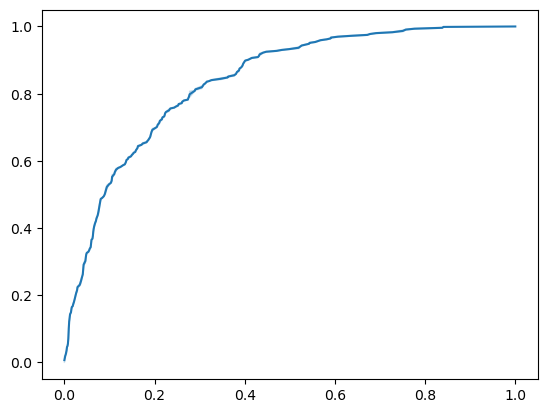

In [50]:
sns.lineplot(y=tpr, x=fpr)
plt.show()

### AUC of ROC curve

In [51]:
import random

In [52]:
success = 0
n = 1000000
y_neg_pred = y_pred[y_val == 0]
y_positive_pred = y_pred[y_val == 1]
for i in range(n):
    pos_ind = random.randint(0, len(y_positive_pred) - 1)
    neg_ind = random.randint(0, len(y_neg_pred) - 1)
    success += (y_positive_pred[pos_ind] > y_neg_pred[neg_ind])
success/n

0.837566

In [53]:
from sklearn.metrics import auc

In [54]:
auc(df_scores_real.false_positive_rate, df_scores_real.true_positive_rate), auc(fpr, tpr)

(0.8372351871301587, 0.8373030714450393)

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_val, y_pred)

0.8373030714450393

In [57]:
y_positive_pred[pos_ind], y_neg_pred[neg_ind]

(0.36315074963162036, 0.017886866208351955)

### Cross validation (K fold)

In [58]:
def train(df, y_train, C=1.0):
    dicts = df[categorical_cols + numeric_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)
    
    return dv, model

In [59]:
dv, model = train(df_train, y_train, 10)

In [60]:
def predict(df: pd.DataFrame, dv: DictVectorizer, model: LogisticRegression):
    dicts = df[categorical_cols + numeric_cols].to_dict(orient='records')
    
    X = dv.transform(dicts)
    return model.predict_proba(X)[:,1]

In [61]:
y_pred = predict(df_val, dv, model)

In [62]:
from sklearn.model_selection import KFold

In [63]:
from tqdm.auto import tqdm

In [64]:
n_split = 10
kfold = KFold(n_splits=n_split, shuffle=True, random_state=42)

scores = []
models = []
Cs = []

Cs_actual = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 10000, 100000, np.infty]

for C in tqdm(Cs_actual, total=len(Cs_actual)):
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        y_train = df_train.churn

        df_val = df_train_full.iloc[val_idx]
        y_val = df_val.churn

        dv, model = train(df_train, y_train, C)

        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)

        models.append(model)
        scores.append(auc)
        Cs.append(C)
    print(f"C = {C}\t mean = {round(np.mean(scores), 3)}\t std = {round(np.std(scores), 3)}")

  0%|          | 0/12 [00:00<?, ?it/s]

C = 0.001	 mean = 0.824	 std = 0.017
C = 0.01	 mean = 0.832	 std = 0.018
C = 0.1	 mean = 0.835	 std = 0.018
C = 0.5	 mean = 0.836	 std = 0.017
C = 1	 mean = 0.837	 std = 0.017
C = 5	 mean = 0.838	 std = 0.017
C = 10	 mean = 0.838	 std = 0.017
C = 100	 mean = 0.838	 std = 0.017
C = 1000	 mean = 0.839	 std = 0.017
C = 10000	 mean = 0.839	 std = 0.017
C = 100000	 mean = 0.839	 std = 0.016
C = inf	 mean = 0.839	 std = 0.016


In [65]:
dv, model = train(df_train_full, df_train_full.churn, 1000)

y_pred = predict(df_test, dv, model)

roc_auc_score(y_test, y_pred)

0.8624776154937013